# Simulation of Maxwell's equations in vacuum using STRUPHY for the spatial discretization

**0.0 Importing packages and dependencies**

In [97]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse       as sparse
from scipy.sparse.linalg import splu
from scipy.sparse import csc_matrix

import hylife.utilitis_FEEC.bsplines             as bsp
import hylife.utilitis_FEEC.projectors_global    as proj_glob

import hylife.utilitis_FEEC.derivatives          as der
import hylife.utilitis_FEEC.evaluation           as eva
import hylife.utilitis_FEEC.mass_matrices        as mass
 
import hylife.utilitis_FEEC.phys_input           as phynput 

import hylife.geometry.mappings_analytical       as mp_a
import hylife.geometry.pull_push                 as psh

**0.1 Domain mapping parameters**

In [98]:
kind_map = 1               #slab geometry
#kind      : 1 (slab), 2 (hollow cylinder), 3 (colella) 

L_map        = [3., 2., 2.] #length of the simulation box 
#params    : slab            --> Lx, Ly, Lz
         # : hollow cylinder --> R1, R2, Lz
         # : colella         --> Lx, Ly, alpha, Lz
        

args_map = kind_map, L_map #putting it together

**0.2 Initialization of electric and magnetic fields, for now as plane waves**

In [99]:
#plane wave vector
k = [1., 1., 0.]

k[0] = k[0] / L_map[0]
k[1] = k[1] / L_map[1]
k[2] = k[2] / L_map[2]

k_norm = np.sqrt(k[0]*k[0] + k[1]*k[1] + k[2]*k[2])

In [100]:
#parameters electric field
a_e = [1.,1.,1.] #amplitude vector
params_input_e = k + a_e

In [101]:
#parameters magnetic field
a_b = [0.,0.,0.] #amplitude vector
params_input_b = k + a_b

In [102]:
#kind of input functions: 1: cosines (for now there is only one implemented, so it can only be 1)
kind_input = 1

**0.3 Time parameters**

In [103]:
#time parameters

T_end = 5. #final time
ntime_it = 500  #number of time iterations
delta_t = T_end/ntime_it  #timestep

## 1. Geometric discretization

**1.1 Spatial parameters**

In [104]:
#spatial parameters
Nel       = [32, 4, 4]             # mesh generation on logical domain
bc        = [True, True, True]     # boundary conditions (True: periodic, False: else)
p         = [2, 1, 1]              # spline degrees 
Nq        = [5, 5, 5]             # number of quadrature points for projection

el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
delta     = [1/Nel for Nel in Nel]                                             # element sizes

T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)
#T contains the coordinates in logical domain

t         = [T[1:-1] for T in T]                                               # reduced knot vectors (for D function)
NbaseN    = [Nel + p - bc*p for Nel, p, bc in zip(Nel, p, bc)]                 # number of basis functions (N functions)
NbaseD    = [NbaseN - (1 - bc) for NbaseN, bc in zip(NbaseN, bc)]              #number of basis functions (D functions)

**1.2 Initialization of projection**

In [105]:
proj_obj = proj_glob.projectors_3d(T, p, bc, Nq)

In [106]:
proj_obj.assemble_V1()
proj_obj.assemble_V2()

**1.3 Projecting the input function, first pulling it to logical space**

In [107]:
ex_coeff = proj_obj.PI_11(lambda xi1, xi2, xi3 : phynput.pull_1(xi1, xi2, xi3, kind_map, L_map, kind_input, params_input_e, 1))
ey_coeff = proj_obj.PI_12(lambda xi1, xi2, xi3 : phynput.pull_1(xi1, xi2, xi3, kind_map, L_map, kind_input, params_input_e, 2))
ez_coeff = proj_obj.PI_13(lambda xi1, xi2, xi3 : phynput.pull_1(xi1, xi2, xi3, kind_map, L_map, kind_input, params_input_e, 3))

e_coeff = ex_coeff, ey_coeff, ez_coeff

In [108]:
bx_coeff = proj_obj.PI_21(lambda xi1, xi2, xi3 : phynput.pull_2(xi1, xi2, xi3, kind_map, L_map, kind_input, params_input_b, 1))
by_coeff = proj_obj.PI_22(lambda xi1, xi2, xi3 : phynput.pull_2(xi1, xi2, xi3, kind_map, L_map, kind_input, params_input_b, 2))
bz_coeff = proj_obj.PI_23(lambda xi1, xi2, xi3 : phynput.pull_2(xi1, xi2, xi3, kind_map, L_map, kind_input, params_input_b, 3))

b_coeff = bx_coeff, by_coeff, bz_coeff

**1.4 Obtaining necessary mass matrices**

In [109]:
M1 = mass.mass_V1_3d(T, p, bc, [None, None], *args_map)
M2 = mass.mass_V2_3d(T, p, bc, [None, None], *args_map)
size = M1.shape[0]

**1.5 Obtaining necessary discrete derivatives**

In [110]:
derivatives = der.discrete_derivatives(T, p, bc)
CURL = derivatives.CURL_3d()

## 2. Time integration of the equations

**2.1 Obtaining and storing the product $M_1^{-1}\mathbb{C}M_2$ as the solution of a sparse linear system (so as to avoid inverting a matrix)**

In [111]:
M1CM2 = sparse.linalg.spsolve(M1.tocsc(), CURL.T.dot(M2))

**2.2 Definition of the time integrators**

2.2.1 Euler explicit

In [112]:
def Euler_integrator(ex_coeff, ey_coeff, ez_coeff, bx_coeff, by_coeff, bz_coeff, ntime_it):
    #if I wanted to take this function outside of this notebook, I would need to pass as arguments M1CM2, CURL and size, and Nel
    
    t = 0
    
    #the input field coefficients need to be flattened for the simulation, 
    #so as to match the dimensions of the mass and derivative matrices
    

    e = np.concatenate( ( ex_coeff.flatten(), ey_coeff.flatten(), ez_coeff.flatten() ) )
    b = np.concatenate( ( bx_coeff.flatten(), by_coeff.flatten(), bz_coeff.flatten() ) )


    #first time iteration


    b = np.column_stack((b, b[:] - delta_t*CURL.dot(e[:]) ))
    e = np.column_stack((e, e[:] + delta_t*( (M1CM2.dot(b[:,t])).T )))
    
    t = 1

    #rest of the simulation

    while t < ntime_it:
    
        #updating the coefficients
    
        b = np.column_stack((b, b[:,t].reshape(size,1) - delta_t*CURL.dot(e[:,t].reshape(size,1)) ))
        e = np.column_stack((e, e[:,t].reshape(size,1) + delta_t*( M1CM2.dot(b[:,t+1].reshape(size,1)) )))
    
    
        #ending the time iteration
    
        t = t + 1
    
    
    #reshaping the solution coefficients
    ex_coeff = e[0:int(size/3),:].reshape(Nel[0],Nel[1],Nel[2],ntime_it + 1)
    ey_coeff = e[int(size/3):2*int(size/3),:].reshape(Nel[0],Nel[1],Nel[2],ntime_it + 1)
    ez_coeff = e[2*int(size/3):size,:].reshape(Nel[0],Nel[1],Nel[2],ntime_it + 1)

    bx_coeff = b[0:int(size/3),:].reshape(Nel[0],Nel[1],Nel[2],ntime_it + 1)
    by_coeff = b[int(size/3):2*int(size/3),:].reshape(Nel[0],Nel[1],Nel[2],ntime_it + 1)
    bz_coeff = b[2*int(size/3):size,:].reshape(Nel[0],Nel[1],Nel[2],ntime_it + 1)
    
    return ex_coeff, ey_coeff, ez_coeff, bx_coeff, by_coeff, bz_coeff

2.2.2 Runge Kutta 4

In [113]:
# Define the vector field for the RK solver:
def F(z, t):
    return np.hstack((-CURL.dot(z[size:]), M1CM2.dot(z[:size]) ))

# Runge-Kutta 4th order for dz/dt = F(z,t)
def RK4(z, t, dt):
    
    k1 = F(z, t)
    k2 = F(z + dt/2*k1, t + dt/2)
    k3 = F(z + dt/2*k2, t + dt/2)
    k4 = F(z + dt*k3, t + dt)
    
    return z + dt/6*k1 + dt/3*k2 + dt/3*k3 + dt/6*k4

def RK4_integrator(ex_coeff, ey_coeff, ez_coeff, bx_coeff, by_coeff, bz_coeff, ntime_it):
    
    t = 0
    
    e = np.concatenate( ( ex_coeff.flatten(), ey_coeff.flatten(), ez_coeff.flatten() ) )
    b = np.concatenate( ( bx_coeff.flatten(), by_coeff.flatten(), bz_coeff.flatten() ) )
    z = np.concatenate( (b,e) )


    #first time iteration


    z = RK4(z, t, delta_t)
    
    b = np.column_stack((b, z[:size]))
    e = np.column_stack((e, z[size:]))


    t = 1

    #rest of the simulation
    while t < ntime_it:
    
        z = RK4(z, t, delta_t) 
        
        b = np.column_stack((b, z[:size]))
        e = np.column_stack((e, z[size:]))
    
        #calculating value on a particular point
       
        t = t + 1
    
    ex_coeff = e[0:int(size/3),:].reshape(Nel[0],Nel[1],Nel[2],ntime_it + 1)
    ey_coeff = e[int(size/3):2*int(size/3),:].reshape(Nel[0],Nel[1],Nel[2],ntime_it + 1)
    ez_coeff = e[2*int(size/3):size,:].reshape(Nel[0],Nel[1],Nel[2],ntime_it + 1)

    bx_coeff = b[0:int(size/3),:].reshape(Nel[0],Nel[1],Nel[2],ntime_it + 1)
    by_coeff = b[int(size/3):2*int(size/3),:].reshape(Nel[0],Nel[1],Nel[2],ntime_it + 1)
    bz_coeff = b[2*int(size/3):size,:].reshape(Nel[0],Nel[1],Nel[2],ntime_it + 1)
    
    return ex_coeff, ey_coeff, ez_coeff, bx_coeff, by_coeff, bz_coeff

**2.3 Calling one of the time integrators (Euler_integrator, RK4_integrator)**

In [114]:
#ex_coeff, ey_coeff, ez_coeff, bx_coeff, by_coeff, bz_coeff = Euler_integrator(*e_coeff, *b_coeff, ntime_it)

In [115]:
ex_coeff, ey_coeff, ez_coeff, bx_coeff, by_coeff, bz_coeff = RK4_integrator(*e_coeff, *b_coeff, ntime_it)

**2.4 Evaluating the finite element fields in time and space**

2.4.1 Taking as input both time and space

In [116]:
def evaluation(ak_coeff, time, x, y, z, kind, k):
    point = [ [x], [y], [z] ]
    return eva.FEM_field_3d(ak_coeff[:,:,:,time].reshape(*Nel), 10*kind + k, point, T, p, bc)

2.4.2 Creating a sequence for all the time iterations, only dependent on space

In [117]:
def evaluation_all_times(ak_coeff, x, y, z, kind, k):
    ak_value = np.empty(ntime_it + 1, dtype = 'float')
    point = [ [x], [y], [z] ]
    
    for t in range(ntime_it + 1):
        ak_value[t] = evaluation(ak_coeff, t, *point, kind, k)
        
    return ak_value

2.4.2 Choose coordinates of point in logical domain on which to evaluate the results

In [118]:
point = [ [el_b[0][round(len(el_b[0])/2)]], [el_b[1][round(len(el_b[1])/2)-1]], [el_b[2][round(len(el_b[2])/2)-1]] ]

If a point on physical space is to be chosen, convert it with the mapping mp_a first to logical coordinates

**2.5 Converting output from logical to physical space**

2.5.1 Creating a functions of the spatial coordinates only to be pushed

In [119]:
ex_value_fun = lambda x, y, z: evaluation_all_times(ex_coeff, x, y, z, 1, 1)
ey_value_fun = lambda x, y, z: evaluation_all_times(ey_coeff, x, y, z, 1, 2)
ez_value_fun = lambda x, y, z: evaluation_all_times(ez_coeff, x, y, z, 1, 3)

bx_value_fun = lambda x, y, z: evaluation_all_times(bx_coeff, x, y, z, 2, 1)
by_value_fun = lambda x, y, z: evaluation_all_times(by_coeff, x, y, z, 2, 2)
bz_value_fun = lambda x, y, z: evaluation_all_times(bz_coeff, x, y, z, 2, 3)

2.5.2 Using the external routines for pushing back to physical space

In [120]:
ex_value_phys = psh.push_1(ex_value_fun, ey_value_fun, ez_value_fun, 1, point[0][0], point[1][0], point[2][0], *args_map)
ey_value_phys = psh.push_1(ey_value_fun, ey_value_fun, ez_value_fun, 2, point[0][0], point[1][0], point[2][0], *args_map)
ez_value_phys = psh.push_1(ez_value_fun, ey_value_fun, ez_value_fun, 3, point[0][0], point[1][0], point[2][0], *args_map)

bx_value_phys = psh.push_2(bx_value_fun, by_value_fun, bz_value_fun, 1, point[0][0], point[1][0], point[2][0], *args_map)
by_value_phys = psh.push_2(by_value_fun, by_value_fun, bz_value_fun, 2, point[0][0], point[1][0], point[2][0], *args_map)
bz_value_phys = psh.push_2(bz_value_fun, by_value_fun, bz_value_fun, 3, point[0][0], point[1][0], point[2][0], *args_map)

## 3. Study of the time evolution of the field on a fixed point in space

We want to verify the dispersion relation of Maxwell's equation in the vacuum

**3.1 Direct visualization of the time evolution**

In [121]:
time_array = np.linspace(0,T_end,ntime_it + 1)

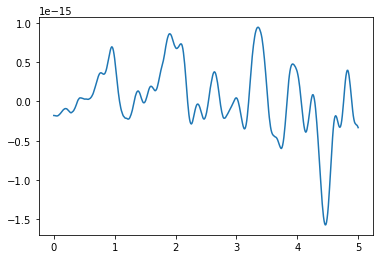

In [122]:
plt.plot(time_array, ex_value_phys)

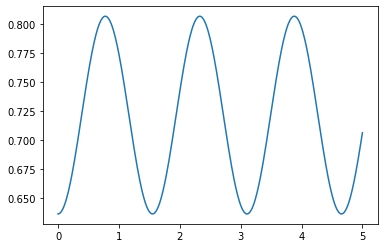

In [123]:
plt.plot(time_array, ey_value_phys)

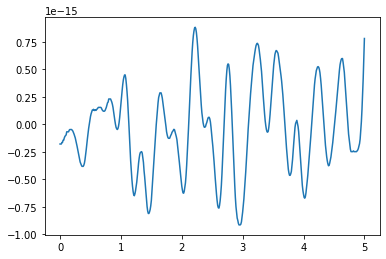

In [124]:
plt.plot(time_array, ez_value_phys)

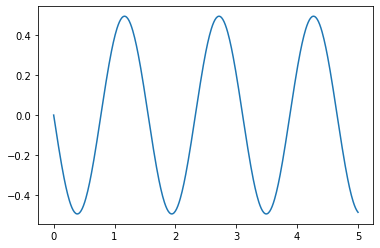

In [125]:
plt.plot(time_array, bx_value_phys)

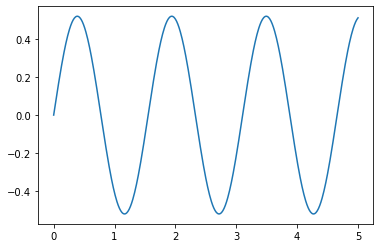

In [126]:
plt.plot(time_array, by_value_phys)

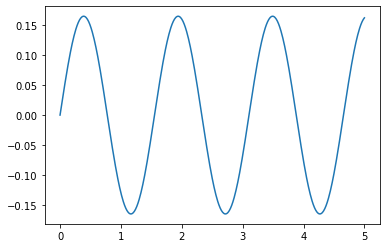

In [127]:
plt.plot(time_array, bz_value_phys)

choose component to be analyzed

In [128]:
component = bz_value_phys

**3.2 Extracting the frequency of oscillation with DFT**

**Initial simple example**

In [129]:
f0 = 50  # Fundamental frequency
Fs = 5000  # Sampling frequency

# Time domain signal
t = np.arange(0, T_end*Fs)/Fs
x = np.sin(2*np.pi*f0*t)
N = x.size

# DFT
X = np.fft.rfft(x)
#X_db = 20*np.log10(2*np.abs(X)/N)
f = np.fft.rfftfreq(N, 1/Fs)
#f = np.fft.fftshift(np.fft.fftfreq(N, 1/Fs))
#f = np.arange(0, N)*Fs/(N)


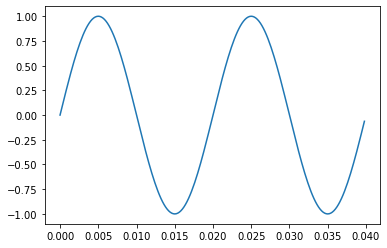

In [130]:
plt.plot(t[0:200],x[0:200])

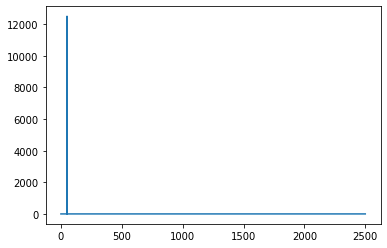

In [131]:
plt.plot(f,abs(X))

In [132]:
m = max(abs(X))

pos_omega = [i for i, j in enumerate(abs(X)) if j == m]

omega = f[pos_omega]

In [133]:
pos_omega

[250]

In [134]:
omega[0]

50.0

**Now our case**

In [135]:
#T_end = 5
#f0 = ?  # Fundamental frequency
Fs = 1/delta_t  # Sampling frequency

# Time domain signal
t = np.arange(0, T_end*Fs)/Fs
x = component[1:len(component)]
N = t.size

In [136]:
# DFT
X = np.fft.rfft(x)
#X_db = 20*np.log10(2*np.abs(X)/N)
f = np.fft.rfftfreq(N+1, 1/Fs)
#f = np.fft.fftshift(np.fft.fftfreq(N, 1/Fs))
#f = np.arange(0, N)*Fs/(N)

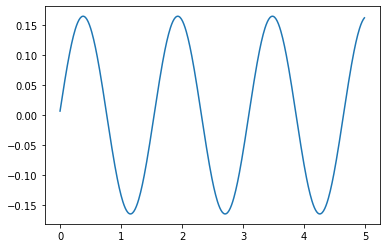

In [137]:
plt.plot(t,x[0:len(t)])

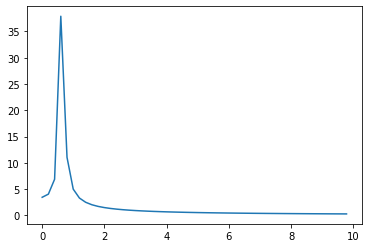

In [138]:
plt.plot(f[0:50],abs(X[0:50]))

In [139]:
m = max(abs(X))

pos_omega = [i for i, j in enumerate(abs(X)) if j == m]

omega = f[pos_omega]

In [140]:
pos_omega

[3]

In [141]:
omega

array([0.5988024])

**3.3 Verification of the dispersion relation**

In [142]:
k_norm

0.6009252125773316

In [143]:
omega

array([0.5988024])

In [144]:
omega[0]/k_norm

0.9964674183686751

The number above should be close to 1! The speed of wave propagation